In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
import seaborn as sns
import PIL
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

c:\Users\sam\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

416
Number of uninfected cells 196
Number of infected cells 220


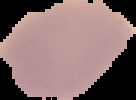

In [3]:
import pathlib
path = "cell_images/"
data_dir = pathlib.Path(path).with_suffix('')

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

uninfected = list(data_dir.glob("Uninfected/*"))
parasitized = list(data_dir.glob("Parasitized/*"))
print("Number of uninfected cells", len(uninfected))
print("Number of infected cells", len(parasitized))

PIL.Image.open(uninfected[1])

In [4]:
uninfected = list(data_dir.glob("Uninfected/*"))
parasitized = list(data_dir.glob("Parasitized/*"))
print("Number of uninfected cells", len(uninfected))
print("Number of infected cells", len(parasitized))

Number of uninfected cells 196
Number of infected cells 220


In [5]:
# Show sample images
PIL.Image.open(uninfected[1]).show()
PIL.Image.open(parasitized[1]).show()

In [6]:
# Analyze dimensions of images
dim1 = []
dim2 = []
uninfected_path='cell_images/Uninfected/'
for image_filename in os.listdir(uninfected_path):
    if not image_filename.endswith(('jpg', 'jpeg', 'png', 'gif')):
        continue
    img = imread(uninfected_path + image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

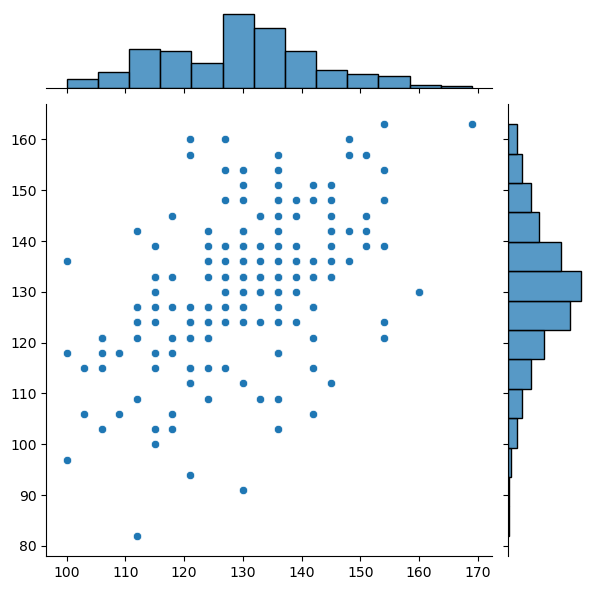

In [7]:
sns.jointplot(x=dim1, y=dim2, kind="scatter")
plt.show()

In [8]:
# Mean dimensions
print("Mean dimensions (uninfected):", np.mean(dim1), np.mean(dim2))

Mean dimensions (uninfected): 129.5408163265306 130.3826530612245


In [9]:
dim1 = []
dim2 = []
infected_path='cell_images/Parasitized/'
for image_filename in os.listdir(infected_path):
    if not image_filename.endswith(('jpg', 'jpeg', 'png', 'gif')):
        continue
    img = imread(infected_path + image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

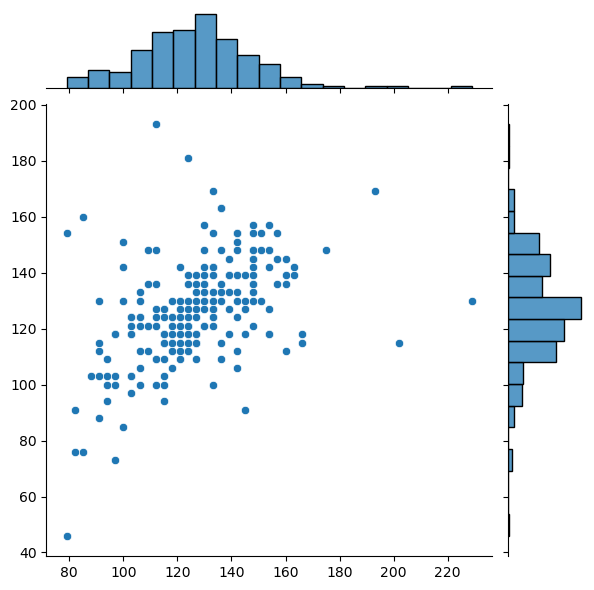

In [10]:
sns.jointplot(x=dim1, y=dim2, kind="scatter")
plt.show()

In [11]:
print("Mean dimensions (infected):", np.mean(dim1), np.mean(dim2))

Mean dimensions (infected): 126.60454545454546 126.19545454545455


In [12]:
# Image preprocessing and augmentation
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.10, height_shift_range=0.10, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest', validation_split=0.3)

In [13]:
# Create a new model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)

In [14]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory('cell_images', target_size=(224, 224), batch_size=32, class_mode='binary', subset='training')
validation_generator = train_datagen.flow_from_directory('cell_images', target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation')

Found 333 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [16]:
# Train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=1)


c:\Users\sam\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 148s 11s/step - accuracy: 0.4589 - loss: 0.9603 - val_accuracy: 0.5542 - val_loss: 0.6843


In [17]:
# Save the model
model.save('model/malaria_detection_model.h5')

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


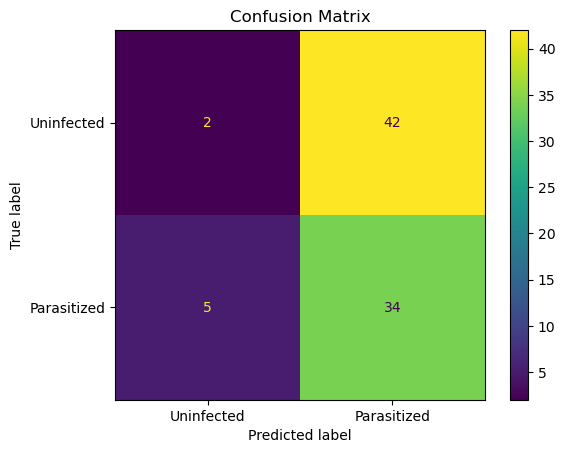

In [18]:
# Confusion Matrix
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Uninfected', 'Parasitized'])
cmd.plot()
plt.title('Confusion Matrix')
plt.show()

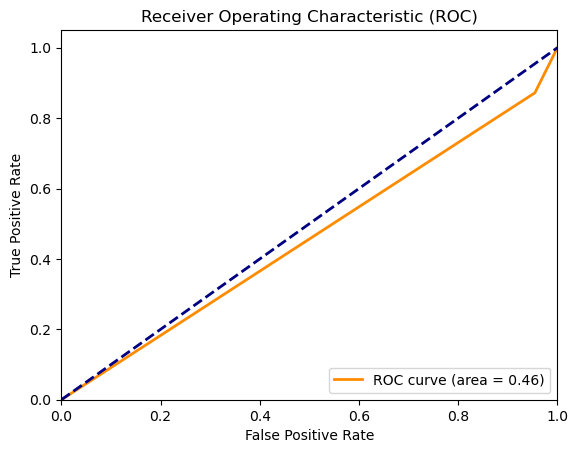

In [19]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")



In [20]:
plt.show()

In [29]:
# Sample Predictions
def plot_sample_predictions(generator, model, num_samples=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img, label = generator.next()
        prediction = model.predict(img)
        plt.imshow(img[0])
        plt.title(f'Label: {label[0]}, Pred: {prediction[0][0]:.2f}')
        plt.axis('off')
    plt.show()

    plot_sample_predictions(validation_generator, model)

In [24]:

# Accuracy and Loss Curves
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

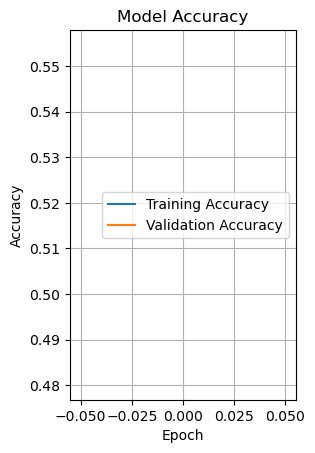

In [25]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

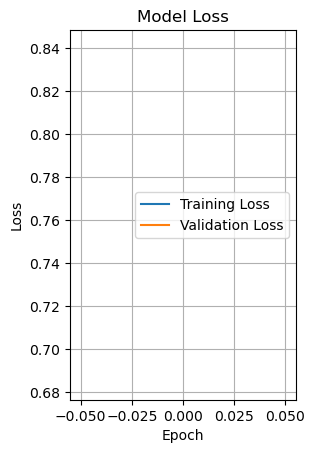

In [26]:
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()